In [1]:
import bruges as bg
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from shapely.affinity import translate

from src.acoustic import AcousticWave2D
from src.model import ModelManager
from utils.dam import create_gravity_dam_mask

def add_dam(model,dz,dx,dam_polygon,dam_position,ground_h):
    nz,nx = model.shape
    dam_mask = translate(dam_polygon, xoff = dam_position[0], yoff = dam_position[1])
    minx_dam = dam_mask.bounds[0]
    minz_dam = dam_mask.bounds[1]
    maxz_dam = dam_mask.bounds[3]
    for i in range(nz):
        for j in range(nx):
            point_pos = (j*dx, ground_h-i*dz)
            if dam_mask.contains(Point(*point_pos)):
                model[i,j] = 4
            else:
                # 上游侧赋予水
                if point_pos[0] <= dam_position[0]:
                    if point_pos[1] > minz_dam and point_pos[1] < maxz_dam:
                        model[i,j] = 1
    return model

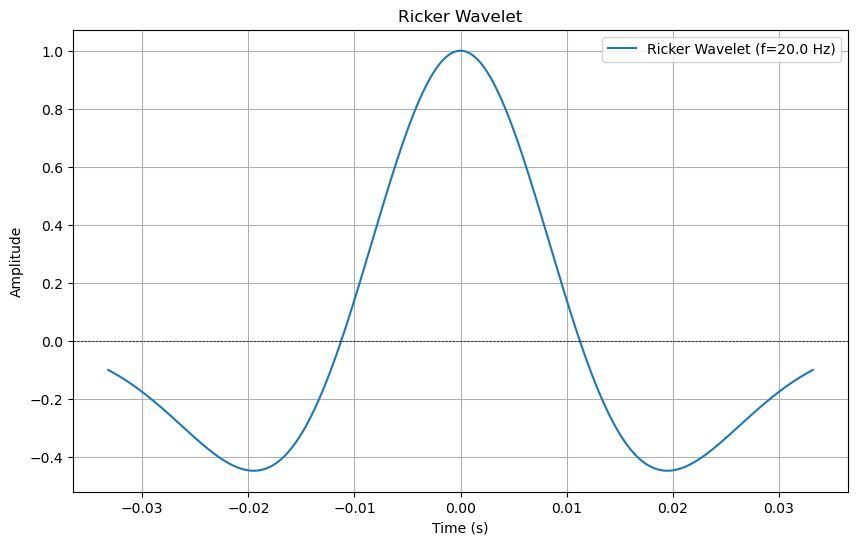

Simulating: 100%|██████████| 8333/8333 [01:16<00:00, 108.30it/s]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (700, 600) to (704, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


MP4 动画已保存为 output\acoustic_wavefield.mp4
检波数据已保存为 output\receiver_data.npy


In [2]:
materials = {
        0: {"v": 340, "rho": 1.225, "name": "Air"},      # 空气
        1: {"v": 1500.0, "rho": 1000.0, "name": "Water"},    # 水
        2: {"v": 1800.0, "rho": 2300.0, "name": "Rock1"},    # 岩石 1
        3: {"v": 2100.0, "rho": 3200.0, "name": "Rock2"},    # 岩石 2
        4: {"v": 3500.0, "rho": 2500.0, "name": "Conc Dam"},    # 混凝土
        # ... 可以继续添加
    }

# 2. 生成模型 (模型矩阵元素为材料编号)
manager = ModelManager()
# 底座蛋糕模型
model = manager.generate_cake_model(depth=(110,300,2),
                                    width=(0,500,2),
                                    strat=(0, (2, 3), 3),
                                    thickness=(1, 1),
                                    mode="linear")
# 上方混凝土重力坝
H = 100           # 坝高
W = 15            # 坝顶宽
slope_up = 0.2   # 上游边坡
slope_dn = 0.5   # 下游边坡
ratio_up = 0.4   # 上游斜面占坝高的比例
ratio_dn = 0.8   # 下游斜面占坝高的比例

dam_polygon = create_gravity_dam_mask(H, W, slope_up, slope_dn, ratio_up, ratio_dn)
# 应用mask
wedge = add_dam(model.wedge,1,1,dam_polygon,(430,0),110)

# manager.visualize_model(wedge, model.top, model.base, 0)

# 3. 定义震源、检波器位置(不含 PML 偏移)
source_position = (370, 20)  # 在物理区 Z=370, X=20 处放一个源
# 定义检波器位置(坝上所有点)
xmin,xmax = int(dam_polygon.bounds[0]),int(dam_polygon.bounds[2])
zmin,zmax = int(dam_polygon.bounds[1]),int(dam_polygon.bounds[3])
receiver_positions = [(x,z+430) for z in range(zmin-2,zmax+2,2) for x in range(xmin-2,xmax+2,2)]

# 4. 创建波场模拟器
simulator = AcousticWave2D(
    model=model.wedge,  # 使用楔形模型
    materials=materials,
    wavelet_type="ricker",
    dz=2.0,
    dx=2.0,
    dt=0.0003,
    tmax=2.5,         # 时间短一些，快速演示
    fm=20.0,
    pml_n=50,         # 30网格厚度的PML
    fd_order=10,
    time_order=2,
    source_position=source_position,
    receiver_positions=receiver_positions,
)

# 可视化震源子波
simulator.show_wavelet()

# 5. 运行正演，获取波场快照
snapshots = simulator.run(save_snapshots=True, snapshot_interval=1)

# 6. 可选：将快照做成动画
simulator.visualize_snapshots(snapshots, dt=100)

# 7. 保存检波器记录
simulator.save_receiver_data("./output/receiver_data.npy")

In [ ]:
# 保存坝相关的波场
simulator.visualize_snapshots(snapshots, dt=10, boundary=(0+50,101+50,430 + xmin-1+50,430 + xmax + 1+50))

D:\downloads\temp\ipykernel_40696\964187651.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis", len(simulator.materials)+1)


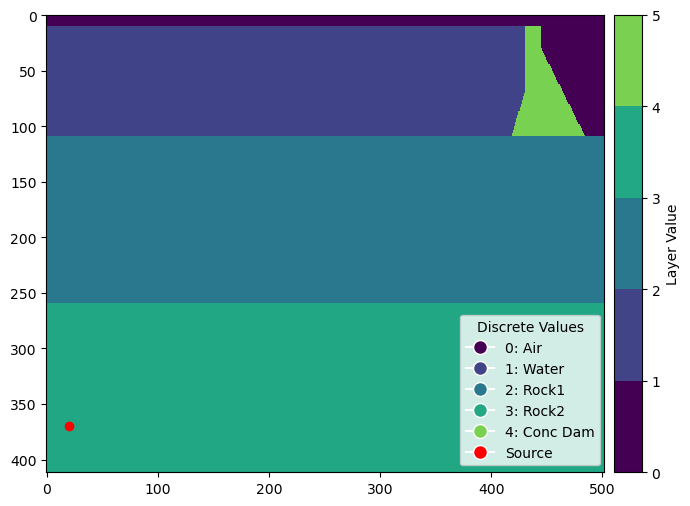

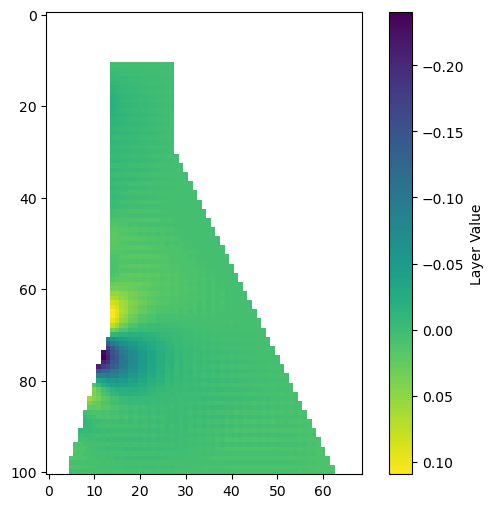

In [23]:
from scipy.ndimage import binary_dilation
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable

cmap = plt.cm.get_cmap("viridis", len(simulator.materials)+1)
norm = mcolors.BoundaryNorm(boundaries=list(simulator.materials.keys())+[5], ncolors=len(simulator.materials))

fig, ax = plt.subplots(figsize=(7, 6))
img = plt.imshow(simulator.model, cmap=cmap, norm=norm, interpolation="none")

labels = {key: value["name"] for key, value in simulator.materials.items()}

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f'{val}: {label}',
           markerfacecolor=img.cmap(img.norm(val)), markersize=10)
    for val, label in labels.items()
]
legend_elements.append(Line2D([0], [0], marker='o', color='w', label="Source",
                               markerfacecolor="red", markersize=10))
plt.plot(20,370, "ro", label="Source")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)  # 调整尺寸和间距
cbar = plt.colorbar(img, cax=cax)
cbar.ax.set_ylabel("Layer Value")  # 添加标签
plt.legend(handles=legend_elements, loc="lower center", title="Discrete Values",
           bbox_to_anchor=(-3, 0),)  # 图例在图像下方居中  # 调整位置，(x, y) 的坐标范围为 [0, 1]
plt.tight_layout()
# plt.show()


# 重力坝波场绘制
boundary=(0+50,101+50,430 + xmin-1+50,430 + xmax + 1+50)
plt.figure(figsize=(7, 6))
mask_dam = simulator.model_padded != 4

dilated = binary_dilation(simulator.model_padded == 4)  # 膨胀内部区域
mask_dam_boundary = dilated & ~(simulator.model_padded == 4)    # 找到边界点

masked_model = np.ma.masked_where(mask_dam, snapshots[7700])
image_simu = masked_model[boundary[0]:boundary[1], boundary[2]:boundary[3]]
image_mask = simulator.model_padded[boundary[0]:boundary[1], boundary[2]:boundary[3]]
plt.imshow(image_simu, interpolation="none")
plt.colorbar(label="Layer Value").ax.invert_yaxis()
plt.show()

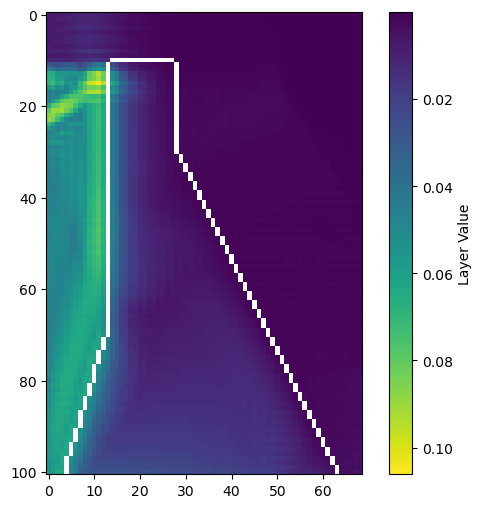

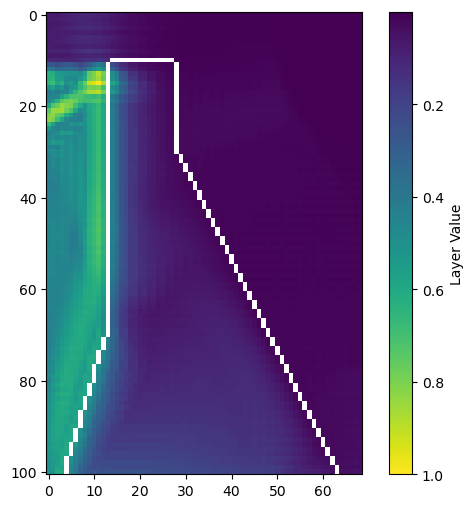

In [41]:
# 所有时刻最大振幅
# dam_max_of_all_time = np.max(np.abs([shot[56:151,467:536] for shot in snapshots]), axis=0)
# masked_model = np.ma.masked_where(mask_dam[56:151,467:536], dam_max_of_all_time)
# image_simu = masked_model

# max_of_all_time = np.max(np.abs(snapshots), axis=0)
# masked_model = np.ma.masked_where(mask_dam_boundary, max_of_all_time)
# image_simu = masked_model[boundary[0]:boundary[1], boundary[2]:boundary[3]]
plt.figure(figsize=(7, 6))
plt.imshow(image_simu, interpolation="none")
plt.colorbar(label="Layer Value").ax.invert_yaxis()
plt.show()

# 所有时刻最大振幅的比例
dam_mask = masked_model[boundary[0]:boundary[1], boundary[2]:boundary[3]]
partition_of_all_time = dam_mask / np.max(np.abs(dam_mask))
plt.figure(figsize=(7, 6))
plt.imshow(partition_of_all_time, interpolation="none")
plt.colorbar(label="Layer Value").ax.invert_yaxis()
plt.show()